# MIO PROJEKT 2 - SIECI KOHONENA

___

## Podstawowa sieć Kohonena
Zaimplementować sieć Kohonena złożoną z neuronów w prostokątnej siatce M×N (M,N są parametrami programu), która działa dla zbioru wektorów (wszystkich o tej samej długości).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import plotly.graph_objects as go
import seaborn as sns
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score, confusion_matrix,f1_score
from scipy.optimize import linear_sum_assignment
import warnings



# neighbourhood functions
def gaussian(x, sigma):
    return np.exp(-(x**2) / (2 * sigma**2))


def gaussian_second_derivative(x, sigma):
    return -(-1 / sigma**2) * (x / sigma)**2 * np.exp(-(x**2) / (2 * sigma**2))


# learning rate decay function
def learning_decay(learning_rate, epoch, decay_coef):
    return learning_rate * np.exp(-epoch / decay_coef)


class SOM:
    def __init__(self, input_dim, map_size, topology='rectangular', X=None):
        self.input_dim = input_dim
        self.map_size = map_size
        self.topology = topology
        self.weights = np.random.randn(*map_size, input_dim)
        if topology == "rectangular":
            self.neighbor_indices = np.indices(self.map_size)
        if topology == "hexagonal":
            self.neighbor_indices = np.indices(self.map_size,dtype=np.float64)
            self.neighbor_indices[0][::2] += 1/2
            self.neighbor_indices[1] *= np.sqrt(3)/2
        
        
        
        

    def train(self, X, epochs, neighborhood_function = gaussian, learning_rate=0.1, sigma=None,learning_rate_decay=None, verbose=False):
        if sigma is None:
            sigma = np.max(self.map_size)
        if learning_rate_decay is None:
            learning_rate_decay = epochs
        
        for epoch in range(epochs):
            if verbose:
                print(f"\r Epoch {epoch+1}/{epochs}",end='')
            current_learning_rate = learning_decay(learning_rate, epoch, learning_rate_decay)
            permutation = np.random.permutation(X.shape[0])
            X_ = X[permutation]
            
            
            for x in X_:
                               
                
                
                # Compute the distances between the input vector and all neurons
                distances = np.linalg.norm(self.weights - x, axis=-1)
                
                # Find the index of the winning neuron
                winner = np.unravel_index(np.argmin(distances), distances.shape)
                
                # Compute the neighborhood function centered around the winner
                neighbor_indices = np.indices(self.map_size)
                neighbor_distances = np.linalg.norm(neighbor_indices - np.array(winner)[:, np.newaxis, np.newaxis], axis=0)
                neighborhood = neighborhood_function(neighbor_distances, sigma)
                
                # Update the weights of all neurons based on the neighborhood function and learning rate
                self.weights += current_learning_rate * neighborhood[..., np.newaxis] * (x - self.weights)
                
    
    
    def find_clusters(self, X):
        # Compute distances between input vectors and all neurons
        winners = []
        for x in X:
                # Compute the distances between the input vector and all neurons
            distances = np.linalg.norm(self.weights - x, axis=-1)
            
            # Find the index of the winning neuron
            winner = np.argmin(distances)
            winners.append(winner)

        return winners


def get_scores(som,X,y):
    y_pred  = som.find_clusters(X)
    h_score = homogeneity_score(y, y_pred)
    c_score = completeness_score(y, y_pred)
    v_score = v_measure_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    row_ind, col_ind = linear_sum_assignment(-conf_matrix)


    y_pred_relabeled = np.zeros_like(y_pred)
    for i, j in zip(col_ind, range(len(y_pred))):
        y_pred_relabeled[y_pred == i] = j
    
    f1 = f1_score(y, y_pred_relabeled, average='macro')
    
    return y_pred_relabeled, y_pred,f1, h_score,c_score,v_score


def coefs_search(X,y, input_dim, map_size, epochs, neighborhood_functions, learning_rates, sigmas, decays,allow_warnings=False, debug=False):
    warnings.filterwarnings("error") if not allow_warnings else warnings.filterwarnings("ignore")
    for neighborhood_function in neighborhood_functions:
        for learning_rate in learning_rates:
            for sigma in sigmas:
                for decay in decays:
                    som = SOM(input_dim=input_dim, map_size=map_size)
                    try:
                        som.train(X, epochs=epochs, neighborhood_function=neighborhood_function, learning_rate=learning_rate, sigma=sigma, learning_rate_decay=decay)
                    except Exception as e:
                        if debug:
                            print(e)
                        print(f"Error with parameters: {neighborhood_function=}, {learning_rate=}, {sigma=}, {decay=}")
                    else: 
                        y_pred_relabeled, y_pred,f1, h_score,c_score,v_score = get_scores(som,X,y)
                        print(f"{v_score=} | function={neighborhood_function.__name__}, {learning_rate=}, {sigma=}, {decay=}")
                    
    warnings.filterwarnings("default")




def plot_clusters_2D(som,df):

    y_pred_relabeled, y_pred, f1, h_score,c_score,v_score = get_scores(som,df[['x','y']].values,df['c'])

    errors = df["c"] != y_pred_relabeled
    y_pred = pd.Series(y_pred)

    palette = sns.color_palette("deep", as_cmap=True, n_colors=len(som.weights))
    all_labels = sorted(set(df["c"]))
    color_map = dict(zip(all_labels, palette))



    fig = plt.figure(figsize=(10,10))
    sns.scatterplot(data=df, x="x", y="y", hue=df["c"], palette=color_map, s=50)
    sns.scatterplot(x=df.loc[errors,"x"],y= df.loc[errors,"y"], hue=y_pred_relabeled[errors], palette=color_map, marker="x", s=100, legend=False)
    plt.scatter(som.weights[:,:,0], som.weights[:,:,1], c="black", marker="P", s=200)
    plt.title(f"completeness={c_score:.2f} | homogeneity={h_score:.2f} | v_measure={v_score:.2f} | f1={f1:.2f}")
    plt.show()  




def get_scores_hex(som,X,y):
    y_pred  = som.find_clusters(X)
    h_score = homogeneity_score(y, y_pred)
    c_score = completeness_score(y, y_pred)
    v_score = v_measure_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)


    labels = np.argmax(conf_matrix,axis=0)
    y_pred_relabeled = np.zeros_like(y_pred)
    for i in range(len(y_pred)):
        for j in range(len(labels)):
            if y_pred[i] == j:
                y_pred_relabeled[i] = labels[j]
                break

    
    
    f1 = f1_score(y, y_pred_relabeled, average='macro')
    
    return y_pred_relabeled, y_pred,f1, h_score,c_score,v_score, labels

### zbiór hexagon 

In [3]:
df = pd.read_csv('data/hexagon.csv')
df.head()

,x,y,c
0,2.402047,3.728695,1
1,-0.660032,7.047206,0
2,2.202839,-2.394303,2
3,3.179183,2.593885,1
4,3.173320,-2.152688,2


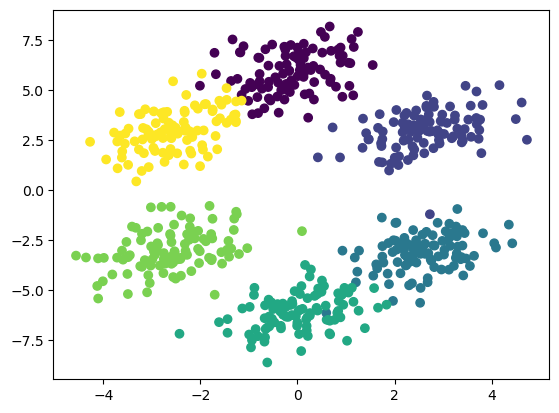

In [5]:
plt.scatter(df['x'],df['y'],c=df['c'])
plt.show()

Widać, że dane ze zbioru to grupy punktów rozłożone w okolicach wierzchołka sześciokąta. W trenowaniu sieci kohonena wykorzystuję kolumny **x** i **y** w celu znalezienia grup **c**. Stosuję uczenie nienadzorowane, czyli nie podaje do sieci wartości **c**. Zachowuję się tak naprawdę jakbym wcale nie miał tych wartości, a wykorzystuję je tylko do porównania modeli przy użyciu **F1_score**.

W celu sprawdzenia działania sieci dla różnych parametrów wykorzystuję grid search. Porównuję wyniki sieci na podstawie statystyki **v_measure_score**.

In [116]:
neighborhood_functions = [gaussian,gaussian_second_derivative]
learning_rates = [0.1,0.01]
sigmas = [0.1,0.5,1]
decays = [10,100]

In [ ]:
coefs_search(df[["x","y"]].values,df["c"],2,(3,2),100,neighborhood_functions,learning_rates,sigmas,decays=decays,allow_warnings=True)

v_score=0.9383662598182816 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=10
v_score=0.9383662598182815 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=100
v_score=0.9323172597177286 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=10
v_score=0.8458718110341035 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=100
v_score=0.8028270883727716 | function=gaussian, learning_rate=0.1, sigma=1, decay=10
v_score=0.8072562040107152 | function=gaussian, learning_rate=0.1, sigma=1, decay=100
v_score=0.9383662598182818 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=10
v_score=0.9383662598182816 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=100
v_score=0.8530353651522178 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=10
v_score=0.905678418962174 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=100
v_score=0.7883455670810462 | function=gaussian, learning_rate=0.01, sigma=1, decay=10
v_score=0.7670110931328836 | function=ga

Widać, że sieci z funkcją sąsiedztwa **gaussian** lepiej dopasowują się do danych, najlepsze wyniki są w pierwszych kilku wierszach outputu.

Dopasowuję model przy użyciu parametrów z pierwszego wiersza outputu z grid search.

In [ ]:
som = SOM(input_dim=2, map_size=(3,2))
som.train(df[["x","y"]].values, epochs=200, neighborhood_function=gaussian, learning_rate=0.1, sigma=0.1, learning_rate_decay=10)

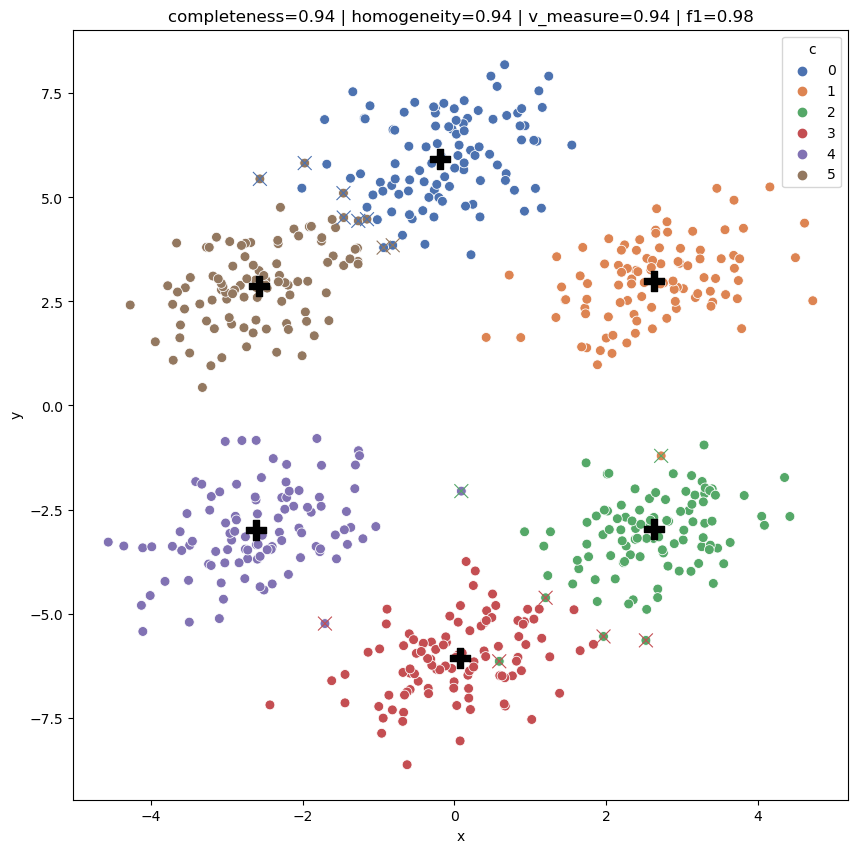

In [ ]:
plot_clusters_2D(som,df)

Widać, że sieć prawie idealnie się dopasowała. Ma problemy głównie z punktami, które są na granicach klastrów. 

Sprawdzę teraz jak wyglądają wyniki z sieci używających drugiej pochodnej funkcji gaussowskiej.

In [108]:
som = SOM(input_dim=2, map_size=(2,3))
som.train(df[["x","y"]].values, epochs=200, neighborhood_function=gaussian_second_derivative, learning_rate=0.5, sigma=100, learning_rate_decay=100)

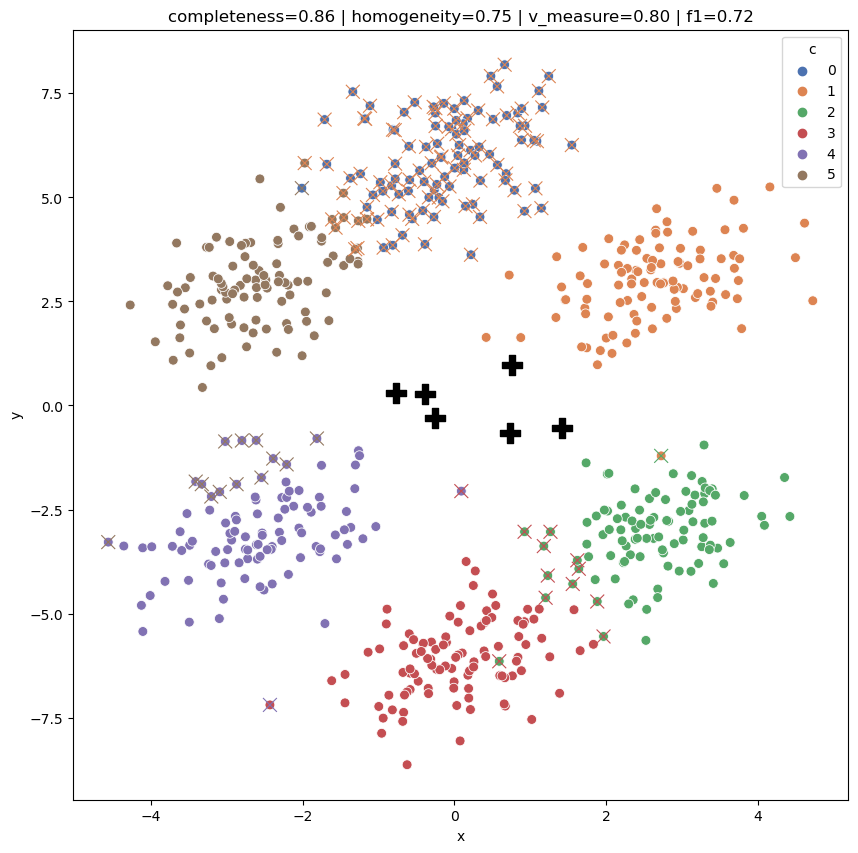

In [109]:
plot_clusters_2D(som,df)

Dla funkcji drugiej pochodnej funkcji gaussowskiej ogólnie mam problemy, bo wydaję mi się, że sieć nie działa tak jak powinna, nieważne jakie dam parametry. Za każdym razem wygląda jakby neurony niewiele się poruszały, to znaczy nigdy nie kończą na środku grupy punktów, tylko zawsze są gdzieś pomiędzy nimi.

Sprawdzałem też wyniki dla większej ilości neuronów niż jest klas jednak nie dawało to lepszych wyników.

### zbiór cube

In [111]:
df = pd.read_csv('data/cube.csv')
df.head()

,x,y,z,c
0,0.187781,0.239537,0.382492,0
1,-1.308979,-0.143321,-0.966648,0
2,-0.987613,0.679918,-0.037552,0
3,0.924980,0.607235,-0.146856,0
4,-0.098663,0.004329,-0.588876,0


In [114]:
warnings.filterwarnings("ignore")
color_map_list = [(k/7, v) for k, v in color_map.items()]
markers = go.Scatter3d(x=df["x"],y=df["y"],z=df["z"],mode='markers',marker=dict(size=3,color=df["c"],colorscale=color_map_list, opacity=0.9))
fig = go.Figure(data=[markers])
fig.update_layout(width=900,height=700,margin=dict(l=0, r=0, b=0, t=10),
                  scene = dict(
                    xaxis=dict(showgrid=False, showbackground=False),
                    yaxis=dict(showgrid=False, showbackground=False),
                    zaxis=dict(showgrid=False, showbackground=False)
                ))

fig.show()
warnings.filterwarnings("default")

Widać, że dane ze zbioru to grupy punktów rozłożone w okolicach wierzchołków sześciokąta. W trenowaniu sieci kohonena wykorzystuję kolumny **x**, **y**, **z** w celu znalezienia grup **c**. W uczeniu nie wykorzystuję **c**.

Grid search dla siatki 4x2

In [ ]:
coefs_search(df[["x","y","z"]].values,df["c"],3,(4,2),100,neighborhood_functions,learning_rates,sigmas,decays=decays,allow_warnings=True)

v_score=0.8261344075857365 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=10
v_score=0.8533882974349145 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=100
v_score=0.9255084669150828 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=10
v_score=0.8750378277176529 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=100
v_score=0.6995308284584794 | function=gaussian, learning_rate=0.1, sigma=1, decay=10
v_score=0.6979636962751447 | function=gaussian, learning_rate=0.1, sigma=1, decay=100
v_score=0.7884220102647198 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=10
v_score=0.7827765109367816 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=100
v_score=0.7151799001466773 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=10
v_score=0.8826049589833852 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=100
v_score=0.6962317848603436 | function=gaussian, learning_rate=0.01, sigma=1, decay=10
v_score=0.699715198496835 | function=ga

Gaussian ma lepsze wyniki, gaussian_second_derivative radzi sobie bardzo źle. Sprawdzam gaussian_second_derivative  na większych sigmach.

In [120]:
coefs_search(df[["x","y","z"]].values,df["c"],3,(4,2),100,[gaussian_second_derivative],learning_rates=learning_rates,sigmas=[10,50,100],decays=decays,allow_warnings=True)

v_score=0.5910935709893387 | function=gaussian_second_derivative, learning_rate=0.1, sigma=10, decay=10
v_score=0.5422080129854725 | function=gaussian_second_derivative, learning_rate=0.1, sigma=10, decay=100
v_score=0.46513420920035164 | function=gaussian_second_derivative, learning_rate=0.1, sigma=50, decay=10
v_score=0.4982639262384565 | function=gaussian_second_derivative, learning_rate=0.1, sigma=50, decay=100
v_score=0.6221714579907048 | function=gaussian_second_derivative, learning_rate=0.1, sigma=100, decay=10
v_score=0.5176894438445181 | function=gaussian_second_derivative, learning_rate=0.1, sigma=100, decay=100
v_score=0.48763125379723943 | function=gaussian_second_derivative, learning_rate=0.01, sigma=10, decay=10
v_score=0.5947332694307227 | function=gaussian_second_derivative, learning_rate=0.01, sigma=10, decay=100
v_score=0.4926338678438968 | function=gaussian_second_derivative, learning_rate=0.01, sigma=50, decay=10
v_score=0.44014253409624476 | function=gaussian_secon

Wyniki nadal słabe.

Sprawdzam jak działa sieć dla siatki 4x3.

In [ ]:
coefs_search(df[["x","y","z"]].values,df["c"],3,(4,3),100,neighborhood_functions,learning_rates,sigmas,decays=decays,allow_warnings=True)

v_score=0.829800079828923 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=10
v_score=0.8139697692646883 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=100
v_score=0.856078903584405 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=10
v_score=0.8463880315684381 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=100
v_score=0.6994959716737736 | function=gaussian, learning_rate=0.1, sigma=1, decay=10
v_score=0.6563719469057725 | function=gaussian, learning_rate=0.1, sigma=1, decay=100
v_score=0.8045662344699269 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=10
v_score=0.8011795206057616 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=100
v_score=0.859741255939307 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=10
v_score=0.8671383818701168 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=100
v_score=0.6662398240918193 | function=gaussian, learning_rate=0.01, sigma=1, decay=10
v_score=0.701783423948206 | function=gauss

Wyniki nie wydają się lepsze niż dla siatki 4x2.

In [123]:
coefs_search(df[["x","y","z"]].values,df["c"],3,(4,3),100,[gaussian_second_derivative],learning_rates=learning_rates,sigmas=[10,50,100],decays=decays,allow_warnings=True)

v_score=0.6099642188457358 | function=gaussian_second_derivative, learning_rate=0.1, sigma=10, decay=10
v_score=0.6374494126365635 | function=gaussian_second_derivative, learning_rate=0.1, sigma=10, decay=100
v_score=0.5608633695451749 | function=gaussian_second_derivative, learning_rate=0.1, sigma=50, decay=10
v_score=0.6184976817429996 | function=gaussian_second_derivative, learning_rate=0.1, sigma=50, decay=100
v_score=0.5416445054679919 | function=gaussian_second_derivative, learning_rate=0.1, sigma=100, decay=10
v_score=0.6005767202324384 | function=gaussian_second_derivative, learning_rate=0.1, sigma=100, decay=100
v_score=0.6282435889518609 | function=gaussian_second_derivative, learning_rate=0.01, sigma=10, decay=10
v_score=0.6137993205686411 | function=gaussian_second_derivative, learning_rate=0.01, sigma=10, decay=100
v_score=0.5849662189224009 | function=gaussian_second_derivative, learning_rate=0.01, sigma=50, decay=10
v_score=0.4681196469195058 | function=gaussian_second_d

Wyniki nadal znacznie gorsze gaussian, więc nie będę się dla tego zbioru przejmował gaussian_second_derivative.

Ogólnie siatka 4x2 dała lepsze wyniki niż 4x4 więc zostanę przy niej.

In [126]:
som = SOM(input_dim=3, map_size=(4,2))
som.train(df[["x","y","z"]].values, epochs=300, neighborhood_function=gaussian, learning_rate=0.01, sigma=0.5, learning_rate_decay=100)

Wykres 2D, widać w tytule, że wyniki miar są dobre i ogólnie sieć dobrze się dopasowała.

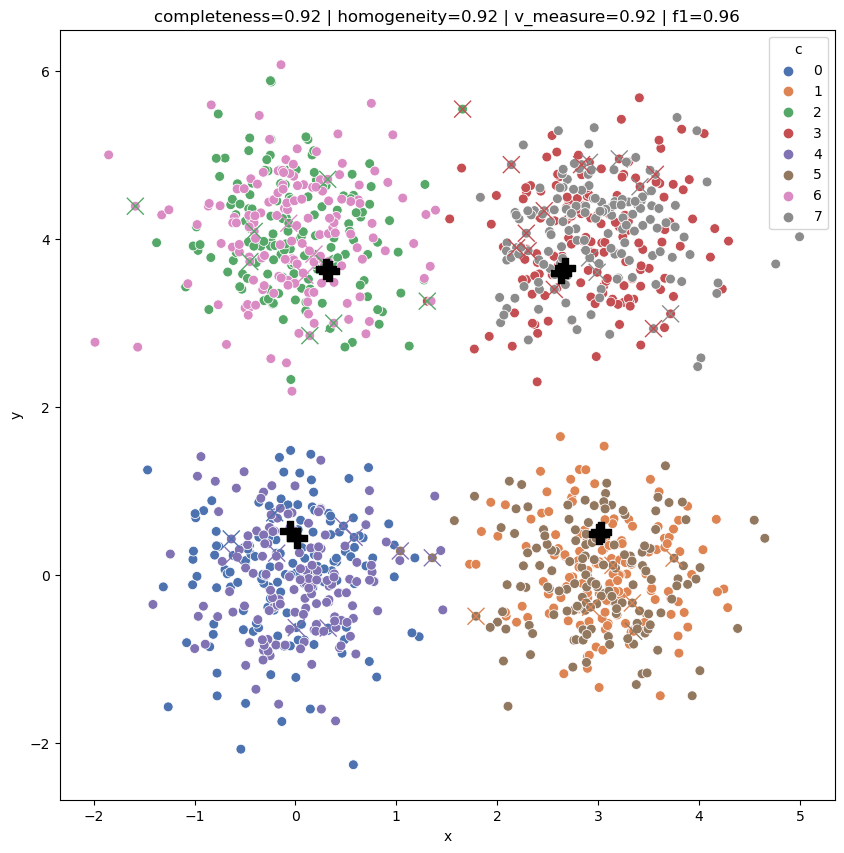

In [ ]:
y_pred_relabeled, y_pred, f1, h_score,c_score,v_score = get_scores(som,df[["x","y","z"]].values,df["c"])

errors = df["c"] != y_pred_relabeled
y_pred = pd.Series(y_pred)

palette = sns.color_palette("deep", as_cmap=True, n_colors=len(som.weights))
all_labels = sorted(set(df["c"]))
color_map = dict(zip(all_labels, palette))


fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x="x", y="y", hue=df["c"], palette=color_map, s=50)
sns.scatterplot(x=df.loc[errors,"x"],y= df.loc[errors,"y"], hue=y_pred_relabeled[errors], palette=color_map, marker="x", s=150, legend=False)
plt.scatter(som.weights[:,:,0], som.weights[:,:,1], c="black", marker="P", s=200)
plt.title(f"completeness={c_score:.2f} | homogeneity={h_score:.2f} | v_measure={v_score:.2f} | f1={f1:.2f}")
plt.show()  

Wykres 3D. Lepiej widać ułożenie neuronów w przestrzeni i klastrów.

In [ ]:
warnings.filterwarnings("ignore")
color_map_list = [(k/7, v) for k, v in color_map.items()]

neurons = go.Scatter3d(x=som.weights[:,:,0].flatten(),y=som.weights[:,:,1].flatten(),z=som.weights[:,:,2].flatten(),
                       mode='markers', marker=dict(size=10,color="black",symbol="cross"))
true_markers = go.Scatter3d(x=df["x"],y=df["y"],z=df["z"],mode='markers',marker=dict(size=3,color=df["c"],colorscale=color_map_list, opacity=0.9))
wrong_markers = go.Scatter3d(x=df.loc[errors,"x"],y= df.loc[errors,"y"], z=df.loc[errors,"z"], 
                   mode='markers',marker=dict(size=4,color=y_pred_relabeled[errors],colorscale=color_map_list,opacity=0.8,symbol='x'))



fig = go.Figure(data=[neurons,true_markers,wrong_markers])#,marker=dict(size=10,color="black"))])
fig.update_layout(width=900,height=700,margin=dict(l=0, r=0, b=0, t=10),
                  scene = dict(
                    xaxis=dict(showgrid=False, showbackground=False),
                    yaxis=dict(showgrid=False, showbackground=False),
                    zaxis=dict(showgrid=False, showbackground=False)
                ))

fig.show()
warnings.filterwarnings("default")
